In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [47]:
df = pd.read_csv('raw_shooter_stats.csv')

cleaned = df[['Player', 'SeasonSort table by Season in ascending order', 'GPSort table by GP in descending order', 'PtsSort table by Pts in ''descending order', 
'Shot QualitySort table by Shot Quality in descending ' 'order', 'eFG%Sort table by eFG% in descending ''order', 'TS%Sort table by TS% in descending order', '3PArSort table by '
'3PAr in descending order', 'UsageSort table by Usage in ''descending order']]

cleaned.columns = [
    'Player',
    'Season',
    'Games_Played',
    'Points',
    'Shot_Quality',
    'eFG%',
    'TS%',
    '3PAr',
    'Usage'
]

percent_cols = ['eFG%', 'TS%', '3PAr']
cleaned = cleaned.copy()
for col in percent_cols:
    cleaned[col] = cleaned[col].str.rstrip('%').astype(float) / 100

cleaned['Gap'] = cleaned['eFG%'] - cleaned['Shot_Quality']

duplicates_mask = cleaned.duplicated(subset=['Player', 'Season'], keep=False)

duplicates = cleaned[duplicates_mask]
uniques = cleaned[~duplicates_mask]

idx_max_games = duplicates.groupby(['Player', 'Season'])['Games_Played'].idxmax()
combined_rows = duplicates.loc[idx_max_games]

cleaned = pd.concat([uniques, combined_rows], ignore_index=True)

cleaned = cleaned.sort_values(['Player', 'Season']).reset_index(drop=True)

cleaned[cleaned['Player'] == 'Josh Giddey']

,Player,Season,Games_Played,Points,Shot_Quality,eFG%,TS%,3PAr,Usage,Gap
7,Josh Giddey,2021-22,54,674.0,0.50,0.4612,0.4773,0.3179,22.44,-0.0388
8,Josh Giddey,2022-23,76,1260.0,0.52,0.5161,0.5362,0.2093,24.35,-0.0039
9,Josh Giddey,2023-24,80,986.0,0.54,0.5230,0.5479,0.2869,22.75,-0.0170
10,Josh Giddey,2024-25,70,1022.0,0.55,0.5307,0.5678,0.3484,21.88,-0.0193


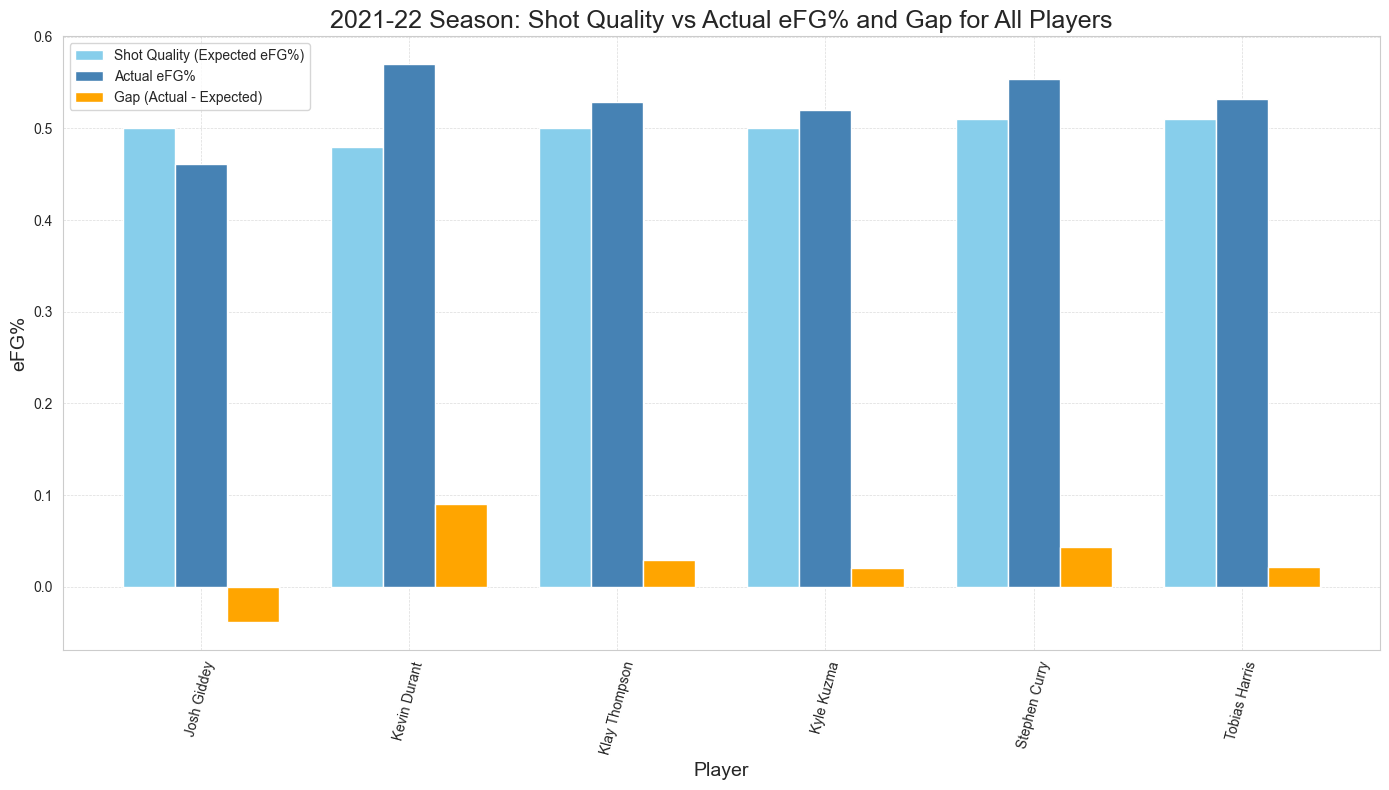

In [52]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

season_data = cleaned[cleaned['Season'] == '2021-22'].sort_values('Player')

# Setup plot style and size
plt.figure(figsize=(14, 8))
sns.set_style("whitegrid")

# Bar width and positions
bar_width = 0.25
x = np.arange(len(season_data))

# Plot bars side-by-side for each player
plt.bar(x - bar_width, season_data['Shot_Quality'], width=bar_width, color='skyblue', edgecolor='white', label='Shot Quality (Expected eFG%)')
plt.bar(x, season_data['eFG%'], width=bar_width, color='steelblue', edgecolor='white', label='Actual eFG%')
plt.bar(x + bar_width, season_data['Gap'], width=bar_width, color='orange', edgecolor='white', label='Gap (Actual - Expected)')

# X-axis labels: Player names, rotated for readability
plt.xticks(x, season_data['Player'], rotation=75, fontsize=10)

# Titles and labels
plt.title('2021-22 Season: Shot Quality vs Actual eFG% and Gap for All Players', fontsize=18)
plt.xlabel('Player', fontsize=14)
plt.ylabel('eFG%', fontsize=14)
plt.legend()
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
plt.tight_layout()
plt.show()
